In [55]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, ReLU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold,cross_val_score
from scipy.stats import ttest_rel

In [56]:
# Load datasets
df1 = pd.read_csv("sqli.csv")
df2 = pd.read_csv("sqliv2.csv")
df3 = pd.read_csv('data.csv')

# Concatenate datasets
df = pd.concat([df2, df1, df3], ignore_index=True)

# Display basic info
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68568 entries, 0 to 68567
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Sentence  68551 non-null  object 
 1   Label     68553 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.0+ MB


,Sentence,Label
0,NaN,1.0
1,""" or pg_sleep ( __TIME__ ) --",1.0
2,create user name identified by pass123 tempora...,1.0
3,%29,1.0
4,' AND 1 = utl_inaddr.get_host_address ( ( S...,1.0


In [57]:
malicious_queries = df[df['Label'] == 1]
common_phrases = malicious_queries.stack().value_counts().head()
print("Most Common Malicious SQL Injection Phrases:\n", common_phrases)


Most Common Malicious SQL Injection Phrases:
 1.0                        23916
s                             14
or 1 = 1                       6
1                              5
" or isNULL ( 1/0 )  /*        5
Name: count, dtype: int64


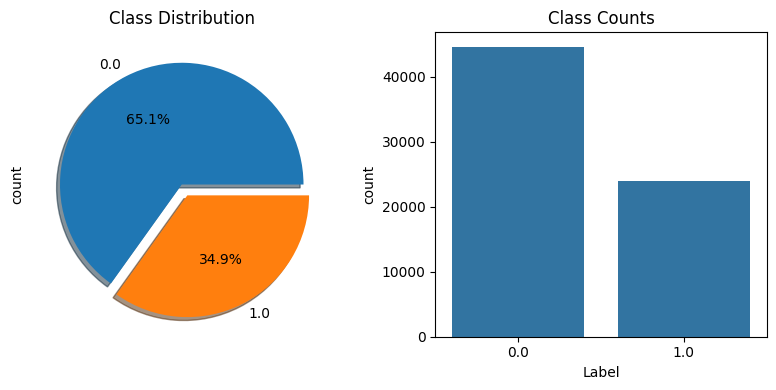

In [58]:
plt.figure(figsize=(8, 4))
# Pie chart
plt.subplot(1, 2, 1)
df['Label'].value_counts().plot.pie(autopct='%1.1f%%', shadow=True, explode=[0, 0.1])
plt.title('Class Distribution')
# Bar chart
plt.subplot(1, 2, 2)
sns.countplot(x='Label', data=df)
plt.title('Class Counts')
plt.tight_layout()
plt.show()


In [59]:
# Convert query textual data into string format
df['Sentence'] = df['Sentence'].astype(str)

# Remove queries containing only two words
df = df[df['Sentence'].str.split().str.len() > 2]

# Drop null values
df.dropna(subset=['Sentence', 'Label'], inplace=True)

# Convert label column to integer
df['Label'] = df['Label'].astype(int)  # Ensure labels are integers

# Prepare features and target
X = df.drop(columns=['Label'])
y = df['Label']

# Encode categorical features
categorical_cols = X.select_dtypes(include=['object']).columns
label_encoder = LabelEncoder()
for col in categorical_cols:
    X[col] = label_encoder.fit_transform(X[col])

# Convert to numeric and handle NaN values using KNN Imputation
X = X.apply(pd.to_numeric, errors='coerce')
imputer = KNNImputer(n_neighbors=5)
X_imputed = imputer.fit_transform(X)
X = pd.DataFrame(X_imputed, columns=X.columns)

# Standardization
scaler = StandardScaler()  
X_scaled = scaler.fit_transform(X)  


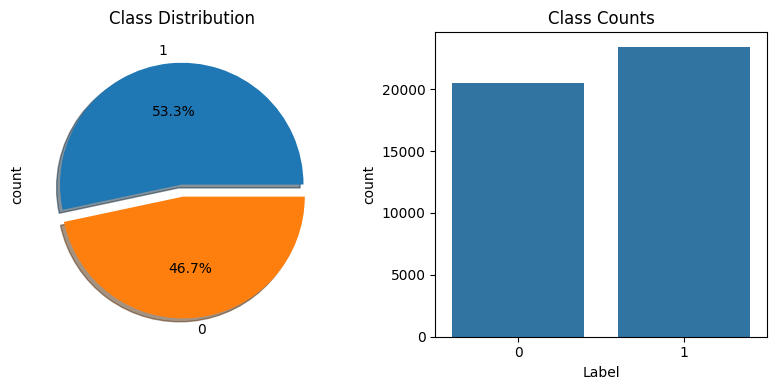

In [60]:
plt.figure(figsize=(8, 4))

# Pie chart
plt.subplot(1, 2, 1)
df['Label'].value_counts().plot.pie(autopct='%1.1f%%', shadow=True, explode=[0, 0.1])
plt.title('Class Distribution')

# Bar chart
plt.subplot(1, 2, 2)
sns.countplot(x='Label', data=df)
plt.title('Class Counts')

plt.tight_layout()
plt.show()


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43930 entries, 1 to 68566
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  43930 non-null  object
 1   Label     43930 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.0+ MB


In [62]:

vectorizer = TfidfVectorizer(max_features=544)  # Ensure 544 features
X_tfidf = vectorizer.fit_transform(df['Sentence']).toarray()
print(X_tfidf.shape)  # Should be (43930, 544)

X_scaled = X_tfidf  # Now X_scaled has 544 features per sample

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


(43930, 544)


In [63]:
input_layer = Input(shape=(544,))  
encoded = Dense(128, activation='relu')(input_layer)
encoded = Dense(64, activation='relu')(encoded)

decoded = Dense(128, activation='relu')(encoded)
decoded = Dense(544, activation='linear')(decoded)
 

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
encoder = Model(input_layer, encoded) 
autoencoder.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 544)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │          69,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 544)                 │          70,176 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,512 (611.38 KB)

 Trainable params: 156,512 (611.38 KB)

 Non-trainable params: 0 (0.00 B)

In [64]:
history = autoencoder.fit(X_train, X_train, 
                          epochs=20, batch_size=128, 
                          validation_data=(X_test, X_test), 
                          verbose=1, 
                          callbacks=[early_stopping, lr_scheduler])


Epoch 1/20
275/275 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0015 - val_loss: 7.7626e-04 - learning_rate: 0.0010
Epoch 2/20
275/275 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 7.0022e-04 - val_loss: 5.8984e-04 - learning_rate: 0.0010
Epoch 3/20
275/275 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 5.4746e-04 - val_loss: 5.0593e-04 - learning_rate: 0.0010
Epoch 4/20
275/275 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 4.7591e-04 - val_loss: 4.5988e-04 - learning_rate: 0.0010
Epoch 5/20
275/275 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 4.4174e-04 - val_loss: 4.3275e-04 - learning_rate: 0.0010
Epoch 6/20
275/275 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 4.1119e-04 - val_loss: 4.1296e-04 - learning_rate: 0.0010
Epoch 7/20
275/275 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 4.0139e-04 - val_loss: 3.9953e-04 - learning_rate: 0.0010
Epoch 8/20
275/275 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 3.8595e-04 - val_loss: 3.8999e-04 - learning_rate: 5.0000e-04
Epoch 9/20
275/275 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - l

In [65]:
X_train_enc = encoder.predict(X_train)
X_val_enc = encoder.predict(X_test)


1099/1099 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step  


In [67]:
xgb = XGBClassifier(n_estimators=100, max_depth=10, learning_rate=0.05, random_state=42)
xgb.fit(X_train_enc, y_train)

y_train_pred = xgb.predict(X_train_enc)
train_accuracy = accuracy_score(y_train, y_train_pred)

y_val_pred = xgb.predict(X_val_enc)
val_accuracy = accuracy_score(y_test, y_val_pred)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")



Train Accuracy: 0.9975
Validation Accuracy: 0.9954


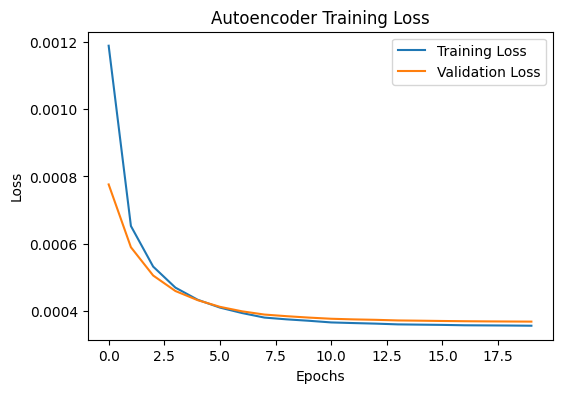

In [68]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Autoencoder Training Loss')
plt.show()


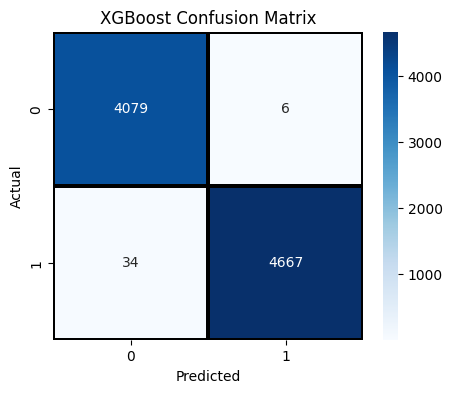


Classification Report:

              precision    recall  f1-score   support

      Normal       0.99      1.00      1.00      4085
   Malicious       1.00      0.99      1.00      4701

    accuracy                           1.00      8786
   macro avg       1.00      1.00      1.00      8786
weighted avg       1.00      1.00      1.00      8786



In [69]:

# Get predictions on test set
y_pred = xgb.predict(X_val_enc)

# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=1.5, linecolor='black')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("XGBoost Confusion Matrix")
plt.show()
# Classification report with a smaller font size
report = classification_report(y_test, y_pred, target_names=["Normal", "Malicious"])
print("\nClassification Report:\n")
print(report)

In [75]:

# K-Fold Cross Validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
kfold_scores = cross_val_score(xgb, X_scaled, y, cv=kf)
print(f'K-Fold Accuracy: {np.mean(kfold_scores):.4f} ± {np.std(kfold_scores):.4f}')

# Statistical T-Test (Requires Numeric Labels)
_, p_value = ttest_rel(y_test, y_val_pred)
print(f'T-Test p-value: {p_value:.4f}')

if p_value < 0.05:
    print("The proposed model is statistically significant.")
else:
    print("No statistical significance found.")

K-Fold Accuracy: 0.9938 ± 0.0011
T-Test p-value: 0.0000
The proposed model is statistically significant.


In [79]:
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score
print("F1-Score :", f1_score(y_test, y_val_pred, average='macro'))
print("Precision-Score :", precision_score(y_test, y_val_pred, average='macro'))
print("Recall-Score :", recall_score(y_test, y_val_pred, average='macro'))
print("Accuracy-Score :", accuracy_score(y_test, y_val_pred))

F1-Score : 0.9954268196674654
Precision-Score : 0.9952247780429696
Recall-Score : 0.9956493540138469
Accuracy-Score : 0.9954473025267471


In [80]:
import joblib
joblib.dump(xgb, 'xgb_model.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')
joblib.dump(encoder, 'encoder.pkl')

['encoder.pkl']

In [81]:
def predict_query(query):
    import numpy as np

    # Preprocess query: convert to lowercase, remove extra spaces
    query_cleaned = query.strip().lower()

    # Vectorize using the same TF-IDF vectorizer
    query_vector = vectorizer.transform([query_cleaned]).toarray()

    # Encode using the trained encoder
    query_encoded = encoder.predict(query_vector)

    # Predict using trained XGBoost model
    prediction = xgb.predict(query_encoded)

    return prediction[0]

# Example usage:
test_query = "SELECT * FROM users WHERE username = 'admin' --' AND password = 'password123';"
predicted_label = predict_query(test_query)
print(f"Prediction for query: \"{test_query}\" → Label: {predicted_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Prediction for query: "SELECT * FROM users WHERE username = 'admin' --' AND password = 'password123';" → Label: 1
